In [1]:
import glob
import json
import os
import re
from pathlib import Path

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns

plt.style.use(["science", "no-latex"])
my_style = {
    "text.usetex": False,
    "figure.constrained_layout.use": True,
    "figure.autolayout": False,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.015,
    "font.size": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.titlesize": 12,
}
plt.rcParams.update(my_style)

# Data Loading

In [2]:
dataset_order = [
    "sinusoidal",
    "bent",
    "mnist",
    "fmnist",
    "breast",
    "derma",
    "oct",
    "organa",
    "organc",
    "organs",
    "path",
    "pneumonia",
    "retina",
    "blood",
    "chest",
    "tissue",
]


def get_simple_name(dataset_name):
    dataset_name = dataset_name.replace("mnist", "") if dataset_name not in ("mnist", "fmnist") else dataset_name
    return dataset_name


def read_metrics_csv_files(file_pattern, with_labels=False):
    all_data = []
    for file_path in glob.glob(file_pattern):
        file = Path(file_path)
        full_dataset_name = file.parent.name

        # Construct the path to experiment_info.json
        experiment_info_path = file.parent / "experiment_info.json"

        # Open and read experiment_info.json
        if experiment_info_path.exists():
            with experiment_info_path.open("r") as info_file:
                experiment_info = json.load(info_file)

        dataset_name = full_dataset_name.split("_")[0]
        df = pd.read_csv(file)
        df["Dataset"] = get_simple_name(dataset_name)  # Add a new column with constant value
        df["N"] = experiment_info["pca_n_components"]
        df["Method"] = df["Method"].apply(lambda s: s.split()[0])
        if with_labels:
            df["Method"] = df["Method"].apply(lambda s: s+"-labels")
            
        df["Split"] = "train" if "_train" in file_path else "test"
        # Query existing levels
        current_levels = list(df.index.names)
        df = df.set_index(["Dataset", "N", "Split"])
        # Create MultiIndex columns
        df = df.pivot(columns="Method", values=["NMSE", "PSNR", "SSI"])
        df.rename(columns={"NMSE": "NRMSE", "SSI": "SSIM"}, level=0, inplace=True)

        # Sort column labels
        df = df.sort_index(axis=1)
        all_data.append(df)

    return pd.concat(all_data).sort_index(
        level=0, key=lambda idx: [dataset_order.index(x) for x in idx.get_level_values("Dataset")], sort_remaining=True
    )

In [3]:
def read_class_csv_files(file_pattern, with_labels=False):    
    all_data = []
    for file_path in glob.glob(file_pattern):
        file = Path(file_path)
        full_dataset_name = file.parent.name

        # Construct the path to experiment_info.json
        experiment_info_path = file.parent / "experiment_info.json"

        # Open and read experiment_info.json
        if experiment_info_path.exists():
            with experiment_info_path.open("r") as info_file:
                experiment_info = json.load(info_file)

        dataset_name = dataset_name = full_dataset_name.split("_")[0]
        df = pd.read_csv(file, header=[0, 1], index_col=[0, 1])
        # Query existing levels
        current_levels = list(df.index.names)
        df["Dataset"] = get_simple_name(dataset_name)  # Add a new column with constant value
        df["N"] = experiment_info["pca_n_components"]
        df = df.set_index(["Dataset", "N"], append=True)
        df = df.reorder_levels(["Dataset", "N"] + current_levels)
        all_data.append(df)

    df = pd.concat(all_data)
    df.columns.set_names("Method", level=1, inplace=True)
    df.rename(columns={"PCA": "PCA"}, level=1, inplace=True)
    df.rename(columns={"Accuracy": "ACC", "F1-Score": "F1"}, level=0, inplace=True)   
    df = df[["ACC", "F1"]]
    df.index = df.index.set_levels(df.index.levels[3].str.lower(), level="Split")
    df =  df.sort_index(
        level=0, key=lambda idx: [dataset_order.index(x) for x in idx.get_level_values("Dataset")], sort_remaining=True
    )
    if with_labels:        
        # Rename "POLCA" to "POLCA-labels" in the second level
        # Get the current column levels
        level_0 = df.columns.get_level_values(0)
        level_1 = df.columns.get_level_values(1)        
        # Create new level_1 with 'POLCA' replaced by 'POLCA-labels'
        new_level_1 = ['POLCA-labels' if x == 'POLCA' else "PCA-labels" for x in level_1]
        new_columns = pd.MultiIndex.from_arrays([level_0, new_level_1], names=[None, 'Method'])
        df.columns = new_columns
        # df = df.xs('POLCA\nlabels', axis=1, level=1)
    
        
    return df

In [4]:
def read_loss_interaction_csv_files(file_pattern):
    all_data = []
    for file_path in glob.glob(file_pattern):
        file = Path(file_path)
        full_dataset_name = file.parent.name

        # Construct the path to experiment_info.json
        experiment_info_path = file.parent / "experiment_info.json"

        # Open and read experiment_info.json
        if experiment_info_path.exists():
            with experiment_info_path.open("r") as info_file:
                experiment_info = json.load(info_file)

        dataset_name = full_dataset_name.split("_")[0]
        df = pd.read_csv(file)
        df["Dataset"] = get_simple_name(dataset_name)  # Add a new column with constant value
        df["losses"] = "$\\frac{" + df["loss1"] + "}{" + df["loss2"] + "}$"
        df = df.drop(["loss1", "loss2"], axis=1)
        # Sort column labels
        # df = df.sort_index(axis=1)
        all_data.append(df)

    return pd.concat(all_data)
    

In [5]:
def read_experiments_config(file_pattern):
    all_data = []
    for file_path in glob.glob(file_pattern):
        file = Path(file_path)
        full_dataset_name = file.parent.name

        # Construct the path to experiment_info.json
        experiment_info_path = file.parent / "experiment_info.json"

        # Open and read experiment_info.json
        if experiment_info_path.exists():
            with experiment_info_path.open("r") as info_file:
                experiment_info = json.load(info_file)
        
        experiment_info["epochs"] =sum(experiment_info["epoch_list"])
        df = pd.DataFrame.from_records([experiment_info]) 
        dataset_name = full_dataset_name.split("_")[0]        
        df["Dataset"] = get_simple_name(dataset_name)  # Add a new column with constant value       
        df = df.drop(["Experiment Name", "Experiment Folder","Experiment Description"], axis=1)        
        all_data.append(df)

    df_all =  pd.concat(all_data)
    df_all = df_all.set_index("Dataset").infer_objects()
    return df_all

## Set experiment directory name

In [6]:
experiment = "experiments_13"
with_labels = False

In [7]:
df_experiments_confs = read_experiments_config(f"output/{experiment}/*/experiment_info*")
df_experiments_confs

,Random Seed,Date and Time,Python Version,PyTorch Version,CUDA Version,CUDNN Version,Device,GPU Type,Number of GPUs,Current GPU,...,epoch_list,lr_schedule,r,c,alpha,beta,gamma,std_noise,blend_prob,epochs
Dataset,,,,,,,,,,,,,,,,,,,,,
organc,5,2024-09-24 03:46:26,"3.12.5 | packaged by conda-forge | (main, Aug ...",2.4.0,12.4,90100,NVIDIA A100 80GB PCIe,"[8, 0]",1,0,...,"[197, 197, 197]","[0.001, 0.0001, 1e-05]",1,0,0.01,0.01,0,0.0,0.25,591
chest,5,2024-09-24 07:18:25,"3.12.5 | packaged by conda-forge | (main, Aug ...",2.4.0,12.4,90100,NVIDIA A100 80GB PCIe,"[8, 0]",1,0,...,"[33, 33, 33]","[0.001, 0.0001, 1e-05]",1,0,0.01,0.01,0,0.0,0.25,99
organs,5,2024-09-24 04:37:22,"3.12.5 | packaged by conda-forge | (main, Aug ...",2.4.0,12.4,90100,NVIDIA A100 80GB PCIe,"[8, 0]",1,0,...,"[184, 184, 184]","[0.001, 0.0001, 1e-05]",1,0,0.01,0.01,0,0.0,0.25,552
sinusoidal,5,2024-09-23 22:34:18,"3.12.5 | packaged by conda-forge | (main, Aug ...",2.4.0,12.4,90100,NVIDIA A100 80GB PCIe,"[8, 0]",1,0,...,"[1250, 1250, 1250]","[0.001, 0.0001, 1e-05]",1,0,0.01,0.01,0,0.0,0.25,3750
path,5,2024-09-24 05:28:42,"3.12.5 | packaged by conda-forge | (main, Aug ...",2.4.0,12.4,90100,NVIDIA A100 80GB PCIe,"[8, 0]",1,0,...,"[29, 29, 29]","[0.0001, 0.0001, 1e-05]",1,0,0.01,0.01,0,0.0,0.25,87
breast,5,2024-09-23 23:05:58,"3.12.5 | packaged by conda-forge | (main, Aug ...",2.4.0,12.4,90100,NVIDIA A100 80GB PCIe,"[8, 0]",1,0,...,"[4000, 4000, 4000]","[0.001, 0.0001, 1e-05]",1,0,0.01,0.01,0,0.0,0.25,12000
blood,5,2024-09-24 06:28:32,"3.12.5 | packaged by conda-forge | (main, Aug ...",2.4.0,12.4,90100,NVIDIA A100 80GB PCIe,"[8, 0]",1,0,...,"[213, 213, 213]","[0.0001, 0.0001, 1e-05]",1,0,0.01,0.01,0,0.0,0.25,639
derma,5,2024-09-24 01:15:20,"3.12.5 | packaged by conda-forge | (main, Aug ...",2.4.0,12.4,90100,NVIDIA A100 80GB PCIe,"[8, 0]",1,0,...,"[364, 364, 364]","[0.0001, 0.0001, 1e-05]",1,0,0.01,0.01,0,0.0,0.25,1092
mnist,5,2024-09-24 09:31:51,"3.12.5 | packaged by conda-forge | (main, Aug ...",2.4.0,12.4,90100,NVIDIA A100 80GB PCIe,"[8, 0]",1,0,...,"[43, 43, 43]","[0.001, 0.0001, 1e-05]",1,0,0.01,0.01,0,0.0,0.25,129


In [8]:
df_metrics = read_metrics_csv_files(f"output/{experiment}/*/image_metrics_*.csv",with_labels=with_labels)
df_metrics.head(6)

NRMSE             PSNR             SSIM        
Method                  PCA   POLCA      PCA    POLCA     PCA   POLCA
Dataset    N  Split                                                  
sinusoidal 8  test   0.1812  0.0056  20.9277  51.1165  0.8468  0.9998
              train  0.1846  0.0037  20.7602  53.9866  0.8396  0.9999
bent       45 test   0.3345  0.1225  14.6565  23.9447  0.5972  0.9580
              train  0.3111  0.0042  15.3228  52.6050  0.6640  0.9999
mnist      11 test   0.5454  0.2599  15.1314  22.0964  0.5013  0.9086
              train  0.5531  0.1496  15.0848  26.5731  0.4956  0.9666

In [9]:
df_class = read_class_csv_files(f"output/{experiment}/*/classification_metrics_*.csv",with_labels=with_labels)
df_class.head(12)

ACC                  F1          
Method                                     PCA     POLCA       PCA     POLCA
Dataset N  Classifier          Split                                        
mnist   11 Linear SVM          test   0.847400  0.965000  0.846933  0.964957
                               train  0.843867  0.966900  0.843271  0.966879
           Logistic Regression test   0.810300  0.949600  0.809644  0.949558
                               train  0.806883  0.949967  0.806158  0.949940
           Perceptron          test   0.699300  0.885900  0.692989  0.887256
                               train  0.688783  0.880983  0.680193  0.882678
           Ridge Classifier    test   0.716700  0.892100  0.690928  0.890863
                               train  0.703367  0.886617  0.675769  0.885034
fmnist  8  Linear SVM          test   0.749300  0.791300  0.745900  0.789013
                               train  0.755800  0.801283  0.751484  0.798523
           Logistic Regression test   0.731400  0.764900  0.728105  0.763173
                               train  0.738550  0.775417  0.734449  0.772547

In [10]:
df_class_aggregated = df_class[["ACC", "F1"]].groupby(level=["Dataset", "N", "Split"]).mean()
df_class_aggregated.head(6)

ACC                  F1          
Method                PCA     POLCA       PCA     POLCA
Dataset N Split                                        
blood   8 test   0.571763  0.645937  0.555154  0.626208
          train  0.573543  0.643657  0.556239  0.623794
breast  8 test   0.745192  0.750000  0.710066  0.692227
          train  0.743590  0.730769  0.715217  0.689384
chest   8 test   0.487396  0.472752  0.019175  0.023787
          train  0.494463  0.481254  0.019048  0.024856

In [11]:
df_joint = df_metrics.join(df_class_aggregated, how="outer")
df_joint.head(6)

NRMSE             PSNR             SSIM               ACC  \
Method               PCA   POLCA      PCA    POLCA     PCA   POLCA       PCA   
Dataset N  Split                                                               
bent    45 test   0.3345  0.1225  14.6565  23.9447  0.5972  0.9580       NaN   
           train  0.3111  0.0042  15.3228  52.6050  0.6640  0.9999       NaN   
blood   8  test   0.1381  0.1385  19.9512  19.9966  0.5123  0.5417  0.571763   
           train  0.1378  0.1181  19.9714  21.3102  0.5151  0.5949  0.573543   
breast  8  test   0.2566  0.2751  20.4567  21.8714  0.3630  0.4696  0.745192   
           train  0.2567  0.0088  20.6007  49.9309  0.3805  0.9983  0.743590   

                                  F1            
Method               POLCA       PCA     POLCA  
Dataset N  Split                                
bent    45 test        NaN       NaN       NaN  
           train       NaN       NaN       NaN  
blood   8  test   0.645937  0.555154  0.626208  
           train  0.643657  0.556239  0.623794  
breast  8  test   0.750000  0.710066  0.692227  
           train  0.730769  0.715217  0.689384

# Latex Results Table

In [12]:
dataset_order = [
    "sinusoidal",
    "bent",
    "mnist",
    "fmnist",
    "breast",
    "derma",
    "oct",
    "organa",
    "organc",
    "organs",
    "path",
    "pneumonia",
    "retina",
    "blood",
    "chest",
    "tissue",
]
# Sort the DataFrame by dataset
df_latex = df_joint.sort_index(
    level=0, key=lambda idx: [dataset_order.index(x) for x in idx.get_level_values("Dataset")], sort_remaining=True
)
df_latex = df_latex.round(2)


df_latex.head(50)

NRMSE         PSNR         SSIM         ACC          F1  \
Method                PCA POLCA    PCA  POLCA   PCA POLCA   PCA POLCA   PCA   
Dataset    N  Split                                                           
sinusoidal 8  test   0.18  0.01  20.93  51.12  0.85  1.00   NaN   NaN   NaN   
              train  0.18  0.00  20.76  53.99  0.84  1.00   NaN   NaN   NaN   
bent       45 test   0.33  0.12  14.66  23.94  0.60  0.96   NaN   NaN   NaN   
              train  0.31  0.00  15.32  52.60  0.66  1.00   NaN   NaN   NaN   
mnist      11 test   0.55  0.26  15.13  22.10  0.50  0.91  0.77  0.92  0.76   
              train  0.55  0.15  15.08  26.57  0.50  0.97  0.76  0.92  0.75   
fmnist     8  test   0.40  0.26  16.19  20.62  0.47  0.75  0.69  0.72  0.67   
              train  0.40  0.21  16.18  22.50  0.47  0.81  0.69  0.73  0.67   
breast     8  test   0.26  0.28  20.46  21.87  0.36  0.47  0.75  0.75  0.71   
              train  0.26  0.01  20.60  49.93  0.38  1.00  0.74  0.73  0.72   
derma      8  test   0.10  0.09  24.84  26.07  0.69  0.72  0.64  0.67  0.56   
              train  0.10  0.08  24.86  26.99  0.69  0.74  0.64  0.67  0.55   
oct        8  test   0.36  0.21  20.20  25.41  0.49  0.75  0.29  0.37  0.19   
              train  0.38  0.17  20.72  28.21  0.54  0.86  0.48  0.58  0.41   
organa     8  test   0.34  0.37  15.92  15.06  0.22  0.24  0.51  0.54  0.49   
              train  0.34  0.08  15.63  27.50  0.23  0.83  0.57  0.59  0.55   
organc     8  test   0.32  0.35  16.40  15.37  0.25  0.24  0.54  0.61  0.51   
              train  0.32  0.06  15.91  30.44  0.24  0.89  0.59  0.66  0.56   
organs     8  test   0.31  0.36  16.67  15.31  0.25  0.21  0.36  0.36  0.31   
              train  0.31  0.07  16.24  28.98  0.24  0.86  0.39  0.40  0.34   
path       8  test   0.16  0.16  20.17  20.25  0.30  0.31  0.47  0.50  0.42   
              train  0.15  0.15  20.85  20.90  0.27  0.28  0.43  0.49  0.38   
pneumonia  8  test   0.13  0.16  22.58  21.27  0.61  0.56  0.80  0.80  0.79   
              train  0.13  0.02  22.74  36.95  0.61  0.96  0.91  0.93  0.91   
retina     8  test   0.15  0.16  26.97  26.41  0.82  0.83  0.48  0.49  0.40   
              train  0.14  0.07  27.10  33.65  0.83  0.93  0.49  0.48  0.42   
blood      8  test   0.14  0.14  19.95  20.00  0.51  0.54  0.57  0.65  0.56   
              train  0.14  0.12  19.97  21.31  0.52  0.59  0.57  0.64  0.56   
chest      8  test   0.18  0.13  20.81  23.38  0.67  0.78  0.49  0.47  0.02   
              train  0.18  0.12  20.76  23.88  0.67  0.79  0.49  0.48  0.02   
tissue     8  test   0.39  0.34  26.91  28.10  0.65  0.71  0.41  0.41  0.33   
              train  0.39  0.34  26.93  28.17  0.65  0.71  0.41  0.41  0.33   

                           
Method              POLCA  
Dataset    N  Split        
sinusoidal 8  test    NaN  
              train   NaN  
bent       45 test    NaN  
              train   NaN  
mnist      11 test   0.92  
              train  0.92  
fmnist     8  test   0.71  
              train  0.72  
breast     8  test   0.69  
              train  0.69  
derma      8  test   0.57  
              train  0.57  
oct        8  test   0.26  
              train  0.53  
organa     8  test   0.52  
              train  0.57  
organc     8  test   0.59  
              train  0.65  
organs     8  test   0.31  
              train  0.36  
path       8  test   0.47  
              train  0.45  
pneumonia  8  test   0.78  
              train  0.93  
retina     8  test   0.43  
              train  0.43  
blood      8  test   0.63  
              train  0.62  
chest      8  test   0.02  
              train  0.02  
tissue     8  test   0.32  
              train  0.32

In [13]:
df_experiments_confs.head(1).to_dict("records")[0]

{'Random Seed': 5,
 'Date and Time': '2024-09-24 03:46:26',
 'Python Version': '3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:36:51) [GCC 12.4.0]',
 'PyTorch Version': '2.4.0',
 'CUDA Version': '12.4',
 'CUDNN Version': 90100,
 'Device': 'NVIDIA A100 80GB PCIe',
 'GPU Type': [8, 0],
 'Number of GPUs': 1,
 'Current GPU': 0,
 'GPU Available': True,
 'CPU Cores': 24,
 'CPU Threads': 24,
 'n_updates': 20000,
 'device': 'cuda',
 'seed': 5,
 'with_labels': False,
 'n_components': 0.5,
 'n_components_multiplier': 1,
 'batch_size': 128,
 'linear': False,
 'list': False,
 'use_dataloader': False,
 'size': 64,
 'exp_dir': 'experiments_13',
 'n_channels': 1,
 'name': 'organcmnist',
 'labels_dict': {'0': 'bladder',
  '1': 'femur-left',
  '2': 'femur-right',
  '3': 'heart',
  '4': 'kidney-left',
  '5': 'kidney-right',
  '6': 'liver',
  '7': 'lung-left',
  '8': 'lung-right',
  '9': 'pancreas',
  '10': 'spleen'},
 'Data range': [0.0, 1.0],
 'Train dataset shape': [12975, 64, 64],
 'Test d

In [14]:
latex_table = df_latex.to_latex(
    multicolumn_format="c",
    # multirow_align="c",
    # hrules = True,
    caption="""Classification Metrics averaged across all Datasets and Image Reconstruction Metris:
    Normalized Root-Mean-Square (NRMSE), Peak Signal to Noise Ratio (PSNR), Structural Similarity Index Metric (SSIM),
    Accuracy and the F1-Score.
    """,
    label="tab:joit_classifier_metrics_comparison",
    position="htbp",
    float_format="%.2f",
    column_format="lcrrlrlrlrlrl",
    na_rep="",
)
latex_table = (
    """\\begingroup
\\setlength{\\tabcolsep}{2pt} % Default value: 6pt
"""
    + latex_table
)
hyper_params = df_experiments_confs.head(1).to_dict("records")[0]

latex_table = latex_table.replace(
    "\\toprule",
    "\\toprule\n"
    + r"Hyperparameters: &  \multicolumn{10}{c}{ "
    + rf"random seed$={hyper_params['seed']}$, $r={hyper_params['r']}$, $c={hyper_params['c']}$,"
    + rf"$\alpha={hyper_params['alpha']}$, $\beta={hyper_params['beta']}$, $\gamma={hyper_params['gamma']}$"
    + r"} \\",
)
latex_table = latex_table.replace("Split", "").replace("Method", "")

latex_table = latex_table.replace("Dataset & N", "Dataset & \\makecell{Latent\\\\size}")
latex_table = latex_table.replace("PCA-labels", "\\makecell{PCA\\\\Labels}")
latex_table = latex_table.replace("POLCA-labels", "\\makecell{POLCA\\\\Labels}")
latex_table = latex_table.replace("ACC", "Accurary").replace("F1", "F1-score")
latex_table = latex_table.replace(
    "\\label{tab:joit_classifier_metrics_comparison}",
    "\\label{tab:joit_classifier_metrics_comparison}\n \\centering \n \\small\n",
)
latex_table = re.sub("multirow.t.", "multirow[c]", latex_table)
# latex_table = re.sub(r"\\cline..-...", "", latex_table)
latex_table = re.sub(r"\\cline{1-13} \\cline{2-13}", r"\\cmidrule{4-13}", latex_table)
latex_table = re.sub(r"NaN", "", latex_table)
latex_table += "\\endgroup"
print(latex_table)

\begingroup
\setlength{\tabcolsep}{2pt} % Default value: 6pt
\begin{table}[htbp]
\caption{Classification Metrics averaged across all Datasets and Image Reconstruction Metris:
    Normalized Root-Mean-Square (NRMSE), Peak Signal to Noise Ratio (PSNR), Structural Similarity Index Metric (SSIM),
    Accuracy and the F1-score-Score.
    }
\label{tab:joit_classifier_metrics_comparison}
 \centering 
 \small

\begin{tabular}{lcrrlrlrlrlrl}
\toprule
Hyperparameters: &  \multicolumn{10}{c}{ random seed$=5$, $r=1$, $c=0$,$\alpha=0.01$, $\beta=0.01$, $\gamma=0$} \\
 &  &  & \multicolumn{2}{c}{NRMSE} & \multicolumn{2}{c}{PSNR} & \multicolumn{2}{c}{SSIM} & \multicolumn{2}{c}{Accurary} & \multicolumn{2}{c}{F1-score} \\
 &  &  & PCA & POLCA & PCA & POLCA & PCA & POLCA & PCA & POLCA & PCA & POLCA \\
Dataset & \makecell{Latent\\size} &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[c]{2}{*}{sinusoidal} & \multirow[c]{2}{*}{8} & test & 0.18 & 0.01 & 20.93 & 51.12 & 0.85 & 1.00 &  &  &  &  \\
 &  &

# Classification Box Plot

In [15]:
# Reshape the DataFrame to long format
df_class_long = (
    df_class.stack(level=[0, 1], future_stack=True)
    .reset_index()
    .rename(columns={"level_4": "Metric", "level_6": "Method", 0: "Value"})
)

df_class_long = pd.DataFrame(df_class_long[df_class_long["Metric"] == "ACC"].copy())
df_class_long.head(10)

,Dataset,N,Classifier,Split,Metric,Method,Value
0,mnist,11,Linear SVM,test,ACC,PCA,0.847400
1,mnist,11,Linear SVM,test,ACC,POLCA,0.965000
4,mnist,11,Linear SVM,train,ACC,PCA,0.843867
5,mnist,11,Linear SVM,train,ACC,POLCA,0.966900
8,mnist,11,Logistic Regression,test,ACC,PCA,0.810300
9,mnist,11,Logistic Regression,test,ACC,POLCA,0.949600
12,mnist,11,Logistic Regression,train,ACC,PCA,0.806883
13,mnist,11,Logistic Regression,train,ACC,POLCA,0.949967
16,mnist,11,Perceptron,test,ACC,PCA,0.699300
17,mnist,11,Perceptron,test,ACC,POLCA,0.885900


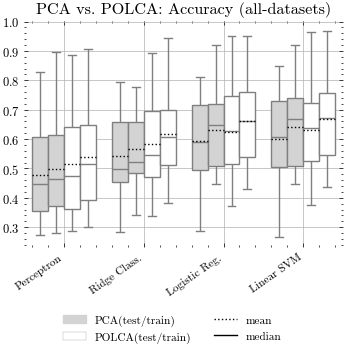

In [16]:
classifier_means = df_class_long.groupby("Classifier")["Value"].mean().sort_values(ascending=True)
classifier_ranks = {classifier: rank for rank, classifier in enumerate(classifier_means.index)}
df_sorted = df_class_long.sort_values(
    by=["Classifier", "Method"], key=lambda x: x.map(classifier_ranks) if x.name == "Classifier" else x
)
df = df_sorted.reset_index(drop=True).copy()

df["Method"] = df["Method"] + "-" + df["Split"]
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.boxplot(
    data=df,
    x="Classifier",
    y="Value",
    hue="Method",
    fill=True,
    palette=["lightgray", "lightgray", "white", "white"],
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
)

plt.xlabel("")
ax.set_ylabel(None)
ax.set_xticks(range(len(df.Classifier.unique())))
ax.legend([])
tlabels = [t.get_text() for t in ax.get_xticklabels()]

tlabels[tlabels.index("Logistic Regression")] = "Logistic Reg."
tlabels[tlabels.index("Ridge Classifier")] = "Ridge Class."
ax.set_xticklabels(tlabels, rotation=35, ha="right", fontsize="xx-small")
ax.set_title("PCA vs. POLCA: Accuracy (all-datasets)", fontsize="small")
ax.grid()

PCA_patch = mpatches.Patch(color="lightgray", label="PCA(test/train)")
POLCA_patch = mpatches.Patch(facecolor="white", label="POLCA(test/train)", edgecolor="k", lw=0.1)
means_leg = mlines.Line2D([], [], ls=":", color="k", marker=None, markersize=15, label="mean")
median_leg = mlines.Line2D([], [], ls="-", color="k", marker=None, markersize=15, label="median")

fig.legend(
    handles=[PCA_patch, POLCA_patch, means_leg, median_leg],
    loc="outside lower center",
    fontsize="xx-small",
    ncols=2,
    borderaxespad=0.0,
)

sns.despine(trim=False, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/classifier_metric_comparison_boxplot_methods.pdf", dpi=300, bbox_inches="tight")

In [17]:
# Reshape the DataFrame
df_metrics_long = (
    df_metrics.stack(level=[0, 1], future_stack=True)
    .reset_index()
    .rename(columns={"level_3": "Metric", "level_4": "Method", 0: "Value"})
)
df_metrics_long

,Dataset,N,Split,Metric,Method,Value
0,sinusoidal,8,test,NRMSE,PCA,0.1812
1,sinusoidal,8,test,NRMSE,POLCA,0.0056
2,sinusoidal,8,test,PSNR,PCA,20.9277
3,sinusoidal,8,test,PSNR,POLCA,51.1165
4,sinusoidal,8,test,SSIM,PCA,0.8468
...,...,...,...,...,...,...
187,tissue,8,train,NRMSE,POLCA,0.3393
188,tissue,8,train,PSNR,PCA,26.9254
189,tissue,8,train,PSNR,POLCA,28.1698
190,tissue,8,train,SSIM,PCA,0.6539


# Reconstruction Box Plot

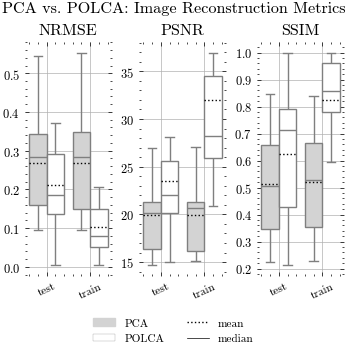

In [18]:
df = df_metrics_long
fig, axs = plt.subplots(1, 3, figsize=(3.5, 3.5))

for ax, metric, title in zip(axs, ["NRMSE", "PSNR", "SSIM"], ["NRMSE", "PSNR", "SSIM"]):
    ax = sns.boxplot(
        data=df[df["Metric"] == metric],
        x="Split",
        y="Value",
        hue="Method",
        fill=True,
        palette={"PCA": "lightgray","PCA-labels": "lightgray", "POLCA": "white", "POLCA-labels": "white"},
        gap=0.0,
        showmeans=True,
        meanprops={"ls": ":", "c": "k"},
        meanline=True,
        showfliers=False,
        fliersize=0.5,
        ax=ax,
        legend=False,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title, fontsize="small")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["test", "train"], rotation=25, ha="center", fontsize="xx-small")
    ax.grid()


plt.suptitle("PCA vs. POLCA: Image Reconstruction Metrics", fontsize="small")

PCA_patch = mpatches.Patch(color="lightgray", label="PCA")
POLCA_patch = mpatches.Patch(facecolor="white", label="POLCA", edgecolor="k", lw=0.1)
means_leg = mlines.Line2D([], [], ls=":", color="k", marker=None, markersize=15, label="mean")
median_leg = mlines.Line2D([], [], ls="-", color="k", marker=None, markersize=15, label="median", lw=0.5)

fig.legend(
    handles=[PCA_patch, POLCA_patch, means_leg, median_leg],
    loc="outside lower center",
    fontsize="xx-small",
    ncols=2,
    borderaxespad=0.0,
)
# Tweak the visual presentation
sns.despine(trim=True, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/image_metrics_comparison_boxplot.pdf", dpi=300, bbox_inches="tight")

# Loss Interaction Box Plot

In [19]:
df_loss = read_loss_interaction_csv_files(f"output/{experiment}/*/loss_interaction_report.csv")

# Step 1: Find the most common relationship for each unique losses value
most_common_relationship = (
    df_loss.groupby("losses")["relationship"].agg(lambda x: x.value_counts().index[0]).reset_index()
)

# Step 2: Create a dictionary for mapping
relationship_mapping = most_common_relationship.set_index("losses")["relationship"].to_dict()

# Step 3: Replace the values in the 'relationship' column
df_loss["common_relationship"] = df_loss["losses"].map(relationship_mapping)

# Step 4: Define the order of relationships from worst to best
relationship_order = [
    "Strongly Conflicting",
    "Conflicting",
    "Weakly Conflicting",
    "Weakly Cooperative",
    "Cooperative",
    "Strongly Cooperative",
]

# Step 5: Create a categorical column with the defined order
df_loss["relationship_category"] = pd.Categorical(
    df_loss["common_relationship"], categories=relationship_order, ordered=True
)


# Step 7: Drop the helper column used for sorting
df_loss = df_loss.drop(columns=["relationship_category"])



df_loss.head(10)

,Unnamed: 0,interactions,conflicts,conflict_rate,avg_similarity,relationship,Dataset,losses,common_relationship
0,0,2936,1317,0.448569,-0.010025,Weakly Conflicting,organc,$\frac{rec}{com}$,Weakly Conflicting
1,1,2936,1040,0.354223,0.028566,Weakly Cooperative,organc,$\frac{rec}{ort}$,Weakly Cooperative
2,2,2936,745,0.253747,0.073070,Weakly Cooperative,organc,$\frac{ort}{com}$,Strongly Cooperative
0,0,2982,1114,0.373575,0.005263,Weakly Cooperative,chest,$\frac{rec}{com}$,Weakly Conflicting
1,1,2982,590,0.197854,0.090191,Weakly Cooperative,chest,$\frac{ort}{com}$,Strongly Cooperative
2,2,2982,947,0.317572,0.101751,Strongly Cooperative,chest,$\frac{rec}{ort}$,Weakly Cooperative
0,0,2932,1041,0.355048,0.000184,Weakly Cooperative,organs,$\frac{rec}{com}$,Weakly Conflicting
1,1,2932,1033,0.352319,0.043681,Weakly Cooperative,organs,$\frac{rec}{ort}$,Weakly Cooperative
2,2,2932,307,0.104707,0.106057,Strongly Cooperative,organs,$\frac{ort}{com}$,Strongly Cooperative
0,0,2716,879,0.323638,-0.006662,Weakly Conflicting,sinusoidal,$\frac{rec}{com}$,Weakly Conflicting


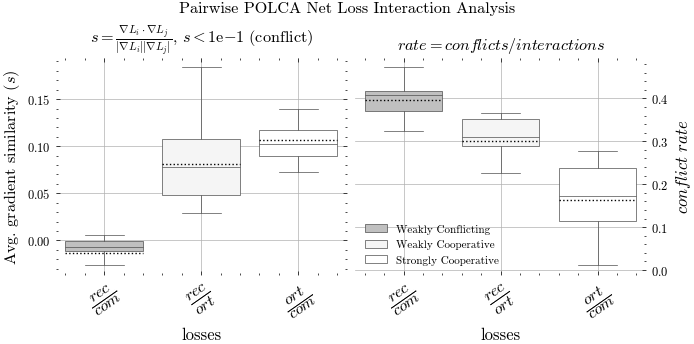

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))
palette = {
    "Strongly Conflicting": "gray",
    "Weakly Conflicting": "silver",
    "Weakly Cooperative": "whitesmoke",
    "Strongly Cooperative": "white",
}

ax1 = sns.boxplot(
    data=df_loss,
    x="losses",
    y="avg_similarity",
    hue="common_relationship",
    fill=True,
    palette=palette,
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
    # color="k",
    linewidth=0.5,
    ax=ax1,
    saturation=0.6,
)
ax1.grid()
ax1.set_ylabel("Avg. gradient similarity ($s$)", fontsize="small")
similarity_form = r"$s=\frac{\nabla L_i \cdot \nabla L_j}{|\nabla L_i| |\nabla L_j|}$"
similarity_form += r", $s<1\mathrm{e}{-1}~(\text{conflict})$"
ax1.set_title(similarity_form,fontsize="small")
ax1.set_xticks(range(len(df_loss["losses"].unique())))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=35, ha="center", fontsize="large")
ax1.legend([])

ax2 = sns.boxplot(
    data=df_loss,
    x="losses",
    y="conflict_rate",
    hue="common_relationship",
    fill=True,
    palette=palette,
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
    # color="k",
    linewidth=0.5,
    ax=ax2,
    saturation=0.6,
)
ax2.grid()
ax2.set_ylabel("$conflict$ $rate$")
ax2.set_title("$rate = conflicts / interactions$",fontsize="small")
ax2.set_xticks(range(len(df_loss["losses"].unique())))
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=35, ha="center", fontsize="large")
# Move the y-axis to the right
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.legend()
plt.suptitle("Pairwise POLCA Net Loss Interaction Analysis", fontsize="small")
sns.despine(trim=False, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/pairwise_loss_conflicts_boxplot.pdf", dpi=300, bbox_inches="tight")